<a href="https://colab.research.google.com/github/rcmckee/Document-Classification/blob/master/tensorflow_Patent_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1UcoQDxQe5MGruMUoD4013HrTz346OH8i'}) 
downloaded.GetContentFile('small_700_through_710_descr_clm_code.csv')  
df = pd.read_csv('small_700_through_710_descr_clm_code.csv')
# Dataset is now stored in a Pandas Dataframe


In [0]:
df.head()

,Unnamed: 0,descr,clm,code
0,0,This application claims priority under 35 U.S....,What is claimed is: \n \n 1 . A pr...,700
1,1,BACKGROUND \n 1. Field of Invention \n ...,What is claimed is: \n \n 1 . A st...,700
2,2,CROSS-REFERENCE TO RELATED APPLICATIONS \n ...,What is claimed is: \n \n 1 . A me...,700
3,3,FIELD OF THE INVENTION \n The present inve...,1 . A method for state-transition-controlled p...,700
4,4,RELATED APPLICATION \n This application cl...,What is claimed is: \n \n 1 . A me...,700


In [0]:
df.drop('Unnamed: 0',axis=1, inplace=True)
df = df[(df['code']==705)|(df['code']==706)|(df['code']==700)]
df['descr_clm'] = df.descr + df.clm
df.drop(['descr','clm'],axis=1, inplace=True)
df['code'] = df['code'].astype('category')
df.head()

,code,descr_clm
0,700,This application claims priority under 35 U.S....
1,700,BACKGROUND \n 1. Field of Invention \n ...
2,700,CROSS-REFERENCE TO RELATED APPLICATIONS \n ...
3,700,FIELD OF THE INVENTION \n The present inve...
4,700,RELATED APPLICATION \n This application cl...


# Data exploration

In [0]:
df['code'].value_counts()

706    1000
705    1000
700    1000
Name: code, dtype: int64

In [0]:
df['category_id'] = df['code'].factorize()[0]

In [0]:
df['category_id'].value_counts()

1    1000
2    1000
0    1000
Name: category_id, dtype: int64

In [0]:
category_id_df = df[['code', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'code']].values)

In [0]:
id_to_category

{0: 700, 1: 705, 2: 706}

In [0]:
df.sample(5, random_state=0)

,code,descr_clm,category_id
2077,700,CROSS-REFERENCE TO RELATED APPLICATION(S) \n ...,0
3401,706,BACKGROUND \n Many systems are instrumente...,2
4393,706,FIELD \n The subject matter disclosed here...,2
10648,705,This application is a continuation of U.S. pat...,1
10687,705,BACKGROUND \n 1. Technical Field \n Em...,1


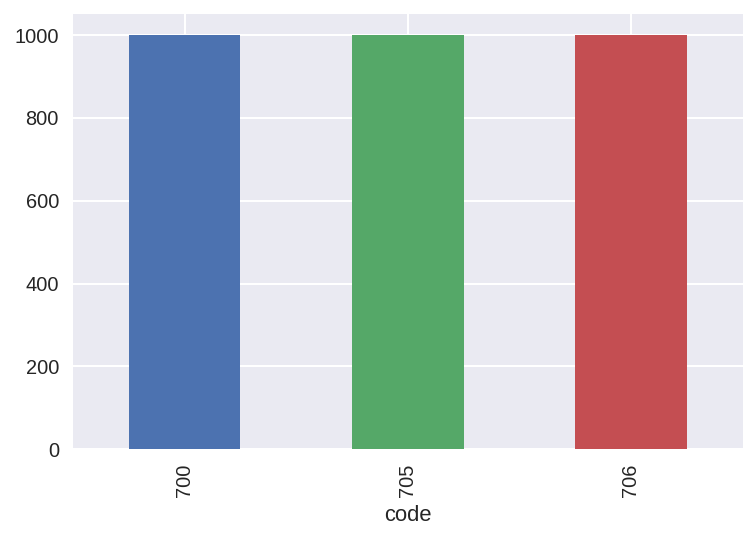

In [0]:
df.groupby('code').descr_clm.count().plot.bar(ylim=0);

# Tf-idf Vectorizer

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df['descr_clm']).toarray()
labels = df['category_id']
features.shape

(3000, 110325)

**3000 applications, represented by 110325 features, representing the tf-idf score for different unigrams and bigrams.**

# Top 10 Uni-Grams and Bi-Grams for each Patent class

In [0]:
from sklearn.feature_selection import chi2

In [0]:
N = 10
for code, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(code))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# '700':
  . Most correlated unigrams:
       . temperature
       . direction
       . motor
       . position
       . sensor
       . controlling
       . power
       . robot
       . control
       . controller
  . Most correlated bigrams:
       . electric power
       . control signal
       . robot according
       . power supply
       . control method
       . method controlling
       . controller configured
       . control unit
       . perspective view
       . control device
# '705':
  . Most correlated unigrams:
       . card
       . price
       . sale
       . financial
       . transactions
       . credit
       . purchase
       . merchant
       . transaction
       . payment
  . Most correlated bigrams:
       . debit card
       . financial transaction
       . account number
       . payment transaction
       . mobile device
       . account associated
       . goods services
       . service provider
       . credit card
       . point sale
# '706':
  . Most

# Model training and evaluation

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

In [0]:
models = [
    RandomForestClassifier(n_estimators=400, max_depth=50, random_state=0),
    MultinomialNB(alpha=0.01),
    LogisticRegression(random_state=0, C=0.9),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

In [0]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


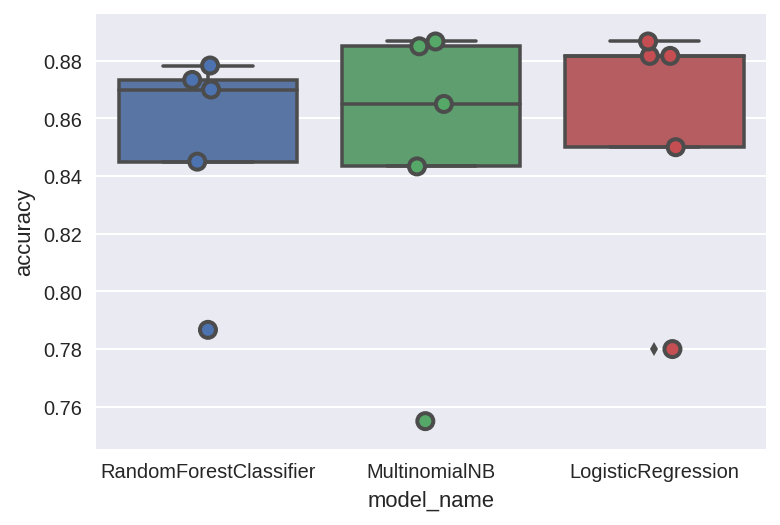

In [0]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2);

In [0]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.856000
MultinomialNB             0.847000
RandomForestClassifier    0.850667
Name: accuracy, dtype: float64

# tensorflow

In [0]:
# Install TF-Hub.
!pip install tensorflow-hub
!pip install seaborn

In [0]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [0]:
df.code = pd.Categorical(df.code)
df['code_num'] = df.code.cat.codes

In [0]:
#model = LogisticRegression(random_state=0, C=0.9)

#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0, stratify=df['code'])
#train_df, test_df = train_test_split(features, labels, df.index, test_size=0.33, random_state=0, stratify=df['code'])
train_df, test_df = train_test_split(df, test_size=0.2)
#model.fit(X_train, y_train)
#y_pred_proba = model.predict_proba(X_test)
#y_pred = model.predict(X_test)

In [0]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df[['descr_clm','category_id']], train_df["category_id"], num_epochs=None, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df[['descr_clm','category_id']], train_df["category_id"], shuffle=False)
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    test_df[['descr_clm','category_id']], test_df["category_id"], shuffle=False)

In [0]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 10667 to 4533
Data columns (total 4 columns):
code           600 non-null category
descr_clm      600 non-null object
category_id    600 non-null int64
code_num       600 non-null int8
dtypes: category(1), int64(1), int8(1), object(1)
memory usage: 15.3+ KB


Feature Columns


In [0]:
embedded_text_feature_column = hub.text_embedding_column(
    key="descr_clm", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

Estimator

In [0]:
estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    n_classes=3,
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmplx0xm6h3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f83e59f4128>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmplx0xm6h3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f83e59f4128>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Training

In [0]:
# Training for 1,000 steps means 128,000 training examples with the default
# batch size. This is roughly equivalent to 5 epochs since the training dataset
# contains 25,000 examples.
estimator.train(input_fn=train_input_fn, steps=1000);

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmplx0xm6h3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmplx0xm6h3/model.ckpt.


INFO:tensorflow:loss = 162.83243, step = 0


INFO:tensorflow:loss = 162.83243, step = 0


INFO:tensorflow:global_step/sec: 4.57238


INFO:tensorflow:global_step/sec: 4.57238


INFO:tensorflow:loss = 57.85409, step = 100 (21.875 sec)


INFO:tensorflow:loss = 57.85409, step = 100 (21.875 sec)


INFO:tensorflow:global_step/sec: 4.48685


INFO:tensorflow:global_step/sec: 4.48685


INFO:tensorflow:loss = 43.335724, step = 200 (22.291 sec)


INFO:tensorflow:loss = 43.335724, step = 200 (22.291 sec)


INFO:tensorflow:global_step/sec: 4.40576


INFO:tensorflow:global_step/sec: 4.40576


INFO:tensorflow:loss = 33.37549, step = 300 (22.696 sec)


INFO:tensorflow:loss = 33.37549, step = 300 (22.696 sec)


INFO:tensorflow:global_step/sec: 4.52469


INFO:tensorflow:global_step/sec: 4.52469


INFO:tensorflow:loss = 37.5486, step = 400 (22.102 sec)


INFO:tensorflow:loss = 37.5486, step = 400 (22.102 sec)


INFO:tensorflow:global_step/sec: 4.48935


INFO:tensorflow:global_step/sec: 4.48935


INFO:tensorflow:loss = 35.32089, step = 500 (22.274 sec)


INFO:tensorflow:loss = 35.32089, step = 500 (22.274 sec)


INFO:tensorflow:global_step/sec: 4.4678


INFO:tensorflow:global_step/sec: 4.4678


INFO:tensorflow:loss = 35.535545, step = 600 (22.381 sec)


INFO:tensorflow:loss = 35.535545, step = 600 (22.381 sec)


INFO:tensorflow:global_step/sec: 4.46671


INFO:tensorflow:global_step/sec: 4.46671


INFO:tensorflow:loss = 40.445213, step = 700 (22.388 sec)


INFO:tensorflow:loss = 40.445213, step = 700 (22.388 sec)


INFO:tensorflow:global_step/sec: 4.04755


INFO:tensorflow:global_step/sec: 4.04755


INFO:tensorflow:loss = 26.982098, step = 800 (24.704 sec)


INFO:tensorflow:loss = 26.982098, step = 800 (24.704 sec)


INFO:tensorflow:global_step/sec: 4.86069


INFO:tensorflow:global_step/sec: 4.86069


INFO:tensorflow:loss = 27.158468, step = 900 (20.574 sec)


INFO:tensorflow:loss = 27.158468, step = 900 (20.574 sec)


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmplx0xm6h3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmplx0xm6h3/model.ckpt.


INFO:tensorflow:Loss for final step: 26.386852.


INFO:tensorflow:Loss for final step: 26.386852.


# Prediction

In [0]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-09-17T16:35:04Z


INFO:tensorflow:Starting evaluation at 2019-09-17T16:35:04Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /tmp/tmplx0xm6h3/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/tmplx0xm6h3/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-09-17-16:35:09


INFO:tensorflow:Finished evaluation at 2019-09-17-16:35:09


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.9291667, average_loss = 0.20721422, global_step = 1000, loss = 26.174429


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.9291667, average_loss = 0.20721422, global_step = 1000, loss = 26.174429


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmplx0xm6h3/model.ckpt-1000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmplx0xm6h3/model.ckpt-1000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-09-17T16:35:10Z


INFO:tensorflow:Starting evaluation at 2019-09-17T16:35:10Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmplx0xm6h3/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/tmplx0xm6h3/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-09-17-16:35:12


INFO:tensorflow:Finished evaluation at 2019-09-17-16:35:12


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.86333334, average_loss = 0.41269088, global_step = 1000, loss = 49.522907


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.86333334, average_loss = 0.41269088, global_step = 1000, loss = 49.522907


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmplx0xm6h3/model.ckpt-1000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmplx0xm6h3/model.ckpt-1000


Training set accuracy: 0.9291666746139526
Test set accuracy: 0.8633333444595337


# Confusion Matrix

In [0]:

from sklearn.metrics import confusion_matrix

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmplx0xm6h3/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/tmplx0xm6h3/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


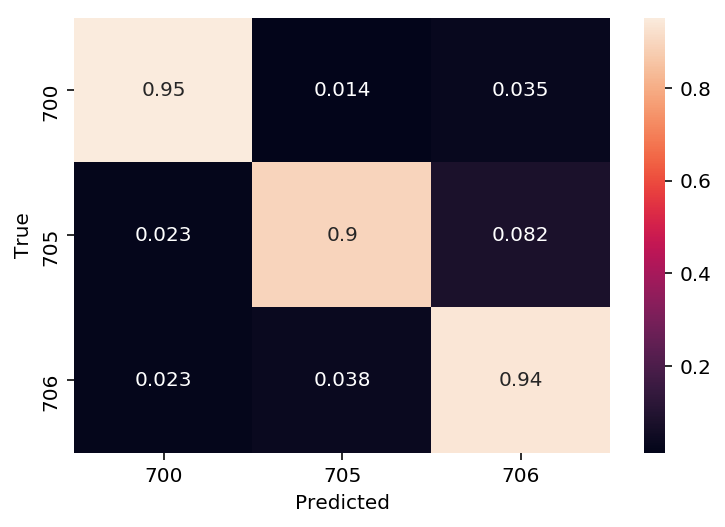

In [0]:
def get_predictions(estimator, input_fn):
  return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "700", "705", "706"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
  cm = tf.confusion_matrix(train_df["category_id"], 
                           get_predictions(estimator, predict_train_input_fn))
  with tf.Session() as session:
    cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");

# Transfer learning analysis

Transfer learning makes it possible to save training resources and to achieve good model generalization even when training on a small dataset. In this part, we will demonstrate this by training with two different TF-Hub modules:

- nnlm-en-dim128 - pretrained text embedding module,
- random-nnlm-en-dim128 - text embedding module that has same vocabulary and network as nnlm-en-dim128, but the weights were just randomly initialized and never trained on real data.

And by training in two modes:

- training only the classifier (i.e. freezing the module), and
- training the classifier together with the module.

In [0]:
def train_and_evaluate_with_module(hub_module, train_module=False):
  embedded_text_feature_column = hub.text_embedding_column(
      key="descr_clm", module_spec=hub_module, trainable=train_module)

  estimator = tf.estimator.DNNClassifier(
      hidden_units=[500, 100],
      feature_columns=[embedded_text_feature_column],
      n_classes=3,
      optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

  estimator.train(input_fn=train_input_fn, steps=1000)

  train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
  test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

  training_set_accuracy = train_eval_result["accuracy"]
  test_set_accuracy = test_eval_result["accuracy"]

  return {
      "Training accuracy": training_set_accuracy,
      "Test accuracy": test_set_accuracy
  }


results = {}
results["nnlm-en-dim128"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/nnlm-en-dim128/1")
results["nnlm-en-dim128-with-module-training"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/nnlm-en-dim128/1", True)
results["random-nnlm-en-dim128"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/random-nnlm-en-dim128/1")
results["random-nnlm-en-dim128-with-module-training"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/random-nnlm-en-dim128/1", True)

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp_cem62bn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f83d760a780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp_cem62bn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f83d760a780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp_cem62bn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp_cem62bn/model.ckpt.


INFO:tensorflow:loss = 142.54924, step = 0


INFO:tensorflow:loss = 142.54924, step = 0


INFO:tensorflow:global_step/sec: 4.60274


INFO:tensorflow:global_step/sec: 4.60274


INFO:tensorflow:loss = 49.73211, step = 100 (21.730 sec)


INFO:tensorflow:loss = 49.73211, step = 100 (21.730 sec)


INFO:tensorflow:global_step/sec: 4.48011


INFO:tensorflow:global_step/sec: 4.48011


INFO:tensorflow:loss = 40.209335, step = 200 (22.324 sec)


INFO:tensorflow:loss = 40.209335, step = 200 (22.324 sec)


INFO:tensorflow:global_step/sec: 4.71844


INFO:tensorflow:global_step/sec: 4.71844


INFO:tensorflow:loss = 29.00753, step = 300 (21.190 sec)


INFO:tensorflow:loss = 29.00753, step = 300 (21.190 sec)


INFO:tensorflow:global_step/sec: 3.86082


INFO:tensorflow:global_step/sec: 3.86082


INFO:tensorflow:loss = 35.08876, step = 400 (25.906 sec)


INFO:tensorflow:loss = 35.08876, step = 400 (25.906 sec)


INFO:tensorflow:global_step/sec: 4.50104


INFO:tensorflow:global_step/sec: 4.50104


INFO:tensorflow:loss = 43.938972, step = 500 (22.218 sec)


INFO:tensorflow:loss = 43.938972, step = 500 (22.218 sec)


INFO:tensorflow:global_step/sec: 4.6611


INFO:tensorflow:global_step/sec: 4.6611


INFO:tensorflow:loss = 26.738804, step = 600 (21.453 sec)


INFO:tensorflow:loss = 26.738804, step = 600 (21.453 sec)


INFO:tensorflow:global_step/sec: 4.26352


INFO:tensorflow:global_step/sec: 4.26352


INFO:tensorflow:loss = 46.934258, step = 700 (23.451 sec)


INFO:tensorflow:loss = 46.934258, step = 700 (23.451 sec)


INFO:tensorflow:global_step/sec: 4.07058


INFO:tensorflow:global_step/sec: 4.07058


INFO:tensorflow:loss = 18.914976, step = 800 (24.570 sec)


INFO:tensorflow:loss = 18.914976, step = 800 (24.570 sec)


INFO:tensorflow:global_step/sec: 4.19134


INFO:tensorflow:global_step/sec: 4.19134


INFO:tensorflow:loss = 26.923618, step = 900 (23.855 sec)


INFO:tensorflow:loss = 26.923618, step = 900 (23.855 sec)


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmp_cem62bn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmp_cem62bn/model.ckpt.


INFO:tensorflow:Loss for final step: 25.01326.


INFO:tensorflow:Loss for final step: 25.01326.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-09-17T16:56:41Z


INFO:tensorflow:Starting evaluation at 2019-09-17T16:56:41Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp_cem62bn/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/tmp_cem62bn/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-09-17-16:56:47


INFO:tensorflow:Finished evaluation at 2019-09-17-16:56:47


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.93916667, average_loss = 0.18987353, global_step = 1000, loss = 23.984024


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.93916667, average_loss = 0.18987353, global_step = 1000, loss = 23.984024


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmp_cem62bn/model.ckpt-1000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmp_cem62bn/model.ckpt-1000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-09-17T16:56:48Z


INFO:tensorflow:Starting evaluation at 2019-09-17T16:56:48Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp_cem62bn/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/tmp_cem62bn/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-09-17-16:56:51


INFO:tensorflow:Finished evaluation at 2019-09-17-16:56:51


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.8566667, average_loss = 0.42759532, global_step = 1000, loss = 51.31144


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.8566667, average_loss = 0.42759532, global_step = 1000, loss = 51.31144


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmp_cem62bn/model.ckpt-1000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmp_cem62bn/model.ckpt-1000


INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpi3zoeag9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f83d89d5b70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpi3zoeag9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f83d89d5b70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpi3zoeag9/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpi3zoeag9/model.ckpt.


INFO:tensorflow:loss = 177.72379, step = 0


INFO:tensorflow:loss = 177.72379, step = 0


INFO:tensorflow:global_step/sec: 2.97377


INFO:tensorflow:global_step/sec: 2.97377


INFO:tensorflow:loss = 30.079922, step = 100 (33.633 sec)


INFO:tensorflow:loss = 30.079922, step = 100 (33.633 sec)


INFO:tensorflow:global_step/sec: 3.23306


INFO:tensorflow:global_step/sec: 3.23306


INFO:tensorflow:loss = 10.636119, step = 200 (30.934 sec)


INFO:tensorflow:loss = 10.636119, step = 200 (30.934 sec)


INFO:tensorflow:global_step/sec: 2.97615


INFO:tensorflow:global_step/sec: 2.97615


INFO:tensorflow:loss = 5.405547, step = 300 (33.594 sec)


INFO:tensorflow:loss = 5.405547, step = 300 (33.594 sec)


INFO:tensorflow:global_step/sec: 2.94724


INFO:tensorflow:global_step/sec: 2.94724


INFO:tensorflow:loss = 3.0099387, step = 400 (33.934 sec)


INFO:tensorflow:loss = 3.0099387, step = 400 (33.934 sec)


INFO:tensorflow:global_step/sec: 2.96762


INFO:tensorflow:global_step/sec: 2.96762


INFO:tensorflow:loss = 2.537506, step = 500 (33.694 sec)


INFO:tensorflow:loss = 2.537506, step = 500 (33.694 sec)


INFO:tensorflow:global_step/sec: 3.15292


INFO:tensorflow:global_step/sec: 3.15292


INFO:tensorflow:loss = 1.7227662, step = 600 (31.716 sec)


INFO:tensorflow:loss = 1.7227662, step = 600 (31.716 sec)


INFO:tensorflow:global_step/sec: 3.39117


INFO:tensorflow:global_step/sec: 3.39117


INFO:tensorflow:loss = 0.92115927, step = 700 (29.491 sec)


INFO:tensorflow:loss = 0.92115927, step = 700 (29.491 sec)


INFO:tensorflow:global_step/sec: 3.30267


INFO:tensorflow:global_step/sec: 3.30267


INFO:tensorflow:loss = 1.8541514, step = 800 (30.277 sec)


INFO:tensorflow:loss = 1.8541514, step = 800 (30.277 sec)


INFO:tensorflow:global_step/sec: 3.1686


INFO:tensorflow:global_step/sec: 3.1686


INFO:tensorflow:loss = 0.9440847, step = 900 (31.564 sec)


INFO:tensorflow:loss = 0.9440847, step = 900 (31.564 sec)


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmpi3zoeag9/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmpi3zoeag9/model.ckpt.


INFO:tensorflow:Loss for final step: 0.34385723.


INFO:tensorflow:Loss for final step: 0.34385723.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-09-17T17:02:33Z


INFO:tensorflow:Starting evaluation at 2019-09-17T17:02:33Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpi3zoeag9/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/tmpi3zoeag9/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-09-17-17:02:42


INFO:tensorflow:Finished evaluation at 2019-09-17-17:02:42


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.99916667, average_loss = 0.0048666843, global_step = 1000, loss = 0.61473906


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.99916667, average_loss = 0.0048666843, global_step = 1000, loss = 0.61473906


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpi3zoeag9/model.ckpt-1000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpi3zoeag9/model.ckpt-1000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-09-17T17:02:43Z


INFO:tensorflow:Starting evaluation at 2019-09-17T17:02:43Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpi3zoeag9/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/tmpi3zoeag9/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-09-17-17:02:46


INFO:tensorflow:Finished evaluation at 2019-09-17-17:02:46


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.88666666, average_loss = 0.57697093, global_step = 1000, loss = 69.23651


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.88666666, average_loss = 0.57697093, global_step = 1000, loss = 69.23651


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpi3zoeag9/model.ckpt-1000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpi3zoeag9/model.ckpt-1000


INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpp9nu81w7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f83d7a74e48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpp9nu81w7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f83d7a74e48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpp9nu81w7/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpp9nu81w7/model.ckpt.


INFO:tensorflow:loss = 477.5921, step = 0


INFO:tensorflow:loss = 477.5921, step = 0


INFO:tensorflow:global_step/sec: 4.32255


INFO:tensorflow:global_step/sec: 4.32255


INFO:tensorflow:loss = 78.20722, step = 100 (23.146 sec)


INFO:tensorflow:loss = 78.20722, step = 100 (23.146 sec)


INFO:tensorflow:global_step/sec: 3.95228


INFO:tensorflow:global_step/sec: 3.95228


INFO:tensorflow:loss = 60.750847, step = 200 (25.298 sec)


INFO:tensorflow:loss = 60.750847, step = 200 (25.298 sec)


INFO:tensorflow:global_step/sec: 3.98366


INFO:tensorflow:global_step/sec: 3.98366


INFO:tensorflow:loss = 54.038666, step = 300 (25.101 sec)


INFO:tensorflow:loss = 54.038666, step = 300 (25.101 sec)


INFO:tensorflow:global_step/sec: 4.42153


INFO:tensorflow:global_step/sec: 4.42153


INFO:tensorflow:loss = 39.528454, step = 400 (22.615 sec)


INFO:tensorflow:loss = 39.528454, step = 400 (22.615 sec)


INFO:tensorflow:global_step/sec: 4.03425


INFO:tensorflow:global_step/sec: 4.03425


INFO:tensorflow:loss = 34.953075, step = 500 (24.787 sec)


INFO:tensorflow:loss = 34.953075, step = 500 (24.787 sec)


INFO:tensorflow:global_step/sec: 3.95222


INFO:tensorflow:global_step/sec: 3.95222


INFO:tensorflow:loss = 35.506588, step = 600 (25.304 sec)


INFO:tensorflow:loss = 35.506588, step = 600 (25.304 sec)


INFO:tensorflow:global_step/sec: 4.33749


INFO:tensorflow:global_step/sec: 4.33749


INFO:tensorflow:loss = 27.45432, step = 700 (23.053 sec)


INFO:tensorflow:loss = 27.45432, step = 700 (23.053 sec)


INFO:tensorflow:global_step/sec: 3.84426


INFO:tensorflow:global_step/sec: 3.84426


INFO:tensorflow:loss = 27.610525, step = 800 (26.018 sec)


INFO:tensorflow:loss = 27.610525, step = 800 (26.018 sec)


INFO:tensorflow:global_step/sec: 3.74081


INFO:tensorflow:global_step/sec: 3.74081


INFO:tensorflow:loss = 26.233051, step = 900 (26.731 sec)


INFO:tensorflow:loss = 26.233051, step = 900 (26.731 sec)


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmpp9nu81w7/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmpp9nu81w7/model.ckpt.


INFO:tensorflow:Loss for final step: 18.48358.


INFO:tensorflow:Loss for final step: 18.48358.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-09-17T17:07:09Z


INFO:tensorflow:Starting evaluation at 2019-09-17T17:07:09Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpp9nu81w7/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/tmpp9nu81w7/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-09-17-17:07:15


INFO:tensorflow:Finished evaluation at 2019-09-17-17:07:15


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.98041666, average_loss = 0.1467842, global_step = 1000, loss = 18.541162


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.98041666, average_loss = 0.1467842, global_step = 1000, loss = 18.541162


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpp9nu81w7/model.ckpt-1000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpp9nu81w7/model.ckpt-1000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-09-17T17:07:15Z


INFO:tensorflow:Starting evaluation at 2019-09-17T17:07:15Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpp9nu81w7/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/tmpp9nu81w7/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-09-17-17:07:18


INFO:tensorflow:Finished evaluation at 2019-09-17-17:07:18


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.70166665, average_loss = 0.8765038, global_step = 1000, loss = 105.18046


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.70166665, average_loss = 0.8765038, global_step = 1000, loss = 105.18046


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpp9nu81w7/model.ckpt-1000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpp9nu81w7/model.ckpt-1000


INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp1ffs2soq', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f839dfd57b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp1ffs2soq', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f839dfd57b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp1ffs2soq/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp1ffs2soq/model.ckpt.


INFO:tensorflow:loss = 356.88544, step = 0


INFO:tensorflow:loss = 356.88544, step = 0


INFO:tensorflow:global_step/sec: 3.07509


INFO:tensorflow:global_step/sec: 3.07509


INFO:tensorflow:loss = 81.48865, step = 100 (32.523 sec)


INFO:tensorflow:loss = 81.48865, step = 100 (32.523 sec)


INFO:tensorflow:global_step/sec: 2.96055


INFO:tensorflow:global_step/sec: 2.96055


INFO:tensorflow:loss = 42.117905, step = 200 (33.777 sec)


INFO:tensorflow:loss = 42.117905, step = 200 (33.777 sec)


INFO:tensorflow:global_step/sec: 3.29675


INFO:tensorflow:global_step/sec: 3.29675


INFO:tensorflow:loss = 41.814453, step = 300 (30.338 sec)


INFO:tensorflow:loss = 41.814453, step = 300 (30.338 sec)


INFO:tensorflow:global_step/sec: 2.99707


INFO:tensorflow:global_step/sec: 2.99707


INFO:tensorflow:loss = 42.588524, step = 400 (33.367 sec)


INFO:tensorflow:loss = 42.588524, step = 400 (33.367 sec)


INFO:tensorflow:global_step/sec: 3.05396


INFO:tensorflow:global_step/sec: 3.05396


INFO:tensorflow:loss = 27.26438, step = 500 (32.742 sec)


INFO:tensorflow:loss = 27.26438, step = 500 (32.742 sec)


INFO:tensorflow:global_step/sec: 2.82862


INFO:tensorflow:global_step/sec: 2.82862


INFO:tensorflow:loss = 23.080372, step = 600 (35.349 sec)


INFO:tensorflow:loss = 23.080372, step = 600 (35.349 sec)


INFO:tensorflow:global_step/sec: 2.79202


INFO:tensorflow:global_step/sec: 2.79202


INFO:tensorflow:loss = 15.338913, step = 700 (35.818 sec)


INFO:tensorflow:loss = 15.338913, step = 700 (35.818 sec)


INFO:tensorflow:global_step/sec: 2.93738


INFO:tensorflow:global_step/sec: 2.93738


INFO:tensorflow:loss = 16.514902, step = 800 (34.045 sec)


INFO:tensorflow:loss = 16.514902, step = 800 (34.045 sec)


INFO:tensorflow:global_step/sec: 3.01825


INFO:tensorflow:global_step/sec: 3.01825


INFO:tensorflow:loss = 12.566394, step = 900 (33.128 sec)


INFO:tensorflow:loss = 12.566394, step = 900 (33.128 sec)


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmp1ffs2soq/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmp1ffs2soq/model.ckpt.


INFO:tensorflow:Loss for final step: 10.689907.


INFO:tensorflow:Loss for final step: 10.689907.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-09-17T17:13:18Z


INFO:tensorflow:Starting evaluation at 2019-09-17T17:13:18Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp1ffs2soq/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/tmp1ffs2soq/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-09-17-17:13:27


INFO:tensorflow:Finished evaluation at 2019-09-17-17:13:27


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.99375, average_loss = 0.07608748, global_step = 1000, loss = 9.611051


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.99375, average_loss = 0.07608748, global_step = 1000, loss = 9.611051


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmp1ffs2soq/model.ckpt-1000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmp1ffs2soq/model.ckpt-1000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-09-17T17:13:27Z


INFO:tensorflow:Starting evaluation at 2019-09-17T17:13:27Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp1ffs2soq/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/tmp1ffs2soq/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-09-17-17:13:31


INFO:tensorflow:Finished evaluation at 2019-09-17-17:13:31


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.74833333, average_loss = 0.797948, global_step = 1000, loss = 95.75376


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.74833333, average_loss = 0.797948, global_step = 1000, loss = 95.75376


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmp1ffs2soq/model.ckpt-1000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmp1ffs2soq/model.ckpt-1000


In [0]:
pd.DataFrame.from_dict(results, orient="index")

,Training accuracy,Test accuracy
nnlm-en-dim128,0.939167,0.856667
nnlm-en-dim128-with-module-training,0.999167,0.886667
random-nnlm-en-dim128,0.980417,0.701667
random-nnlm-en-dim128-with-module-training,0.993750,0.748333


In [0]:
estimator.evaluate(input_fn=predict_test_input_fn)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-09-17T17:21:52Z


INFO:tensorflow:Starting evaluation at 2019-09-17T17:21:52Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmplx0xm6h3/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/tmplx0xm6h3/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-09-17-17:21:55


INFO:tensorflow:Finished evaluation at 2019-09-17-17:21:55


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.86333334, average_loss = 0.41269088, global_step = 1000, loss = 49.522907


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.86333334, average_loss = 0.41269088, global_step = 1000, loss = 49.522907


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmplx0xm6h3/model.ckpt-1000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmplx0xm6h3/model.ckpt-1000


{'accuracy': 0.86333334,
 'average_loss': 0.41269088,
 'global_step': 1000,
 'loss': 49.522907}